### Problem 3

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CyclicLR
%matplotlib inline
from torchsummary import summary

# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 26421880/26421880 [00:03<00:00, 8502762.17it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208732.53it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2599474.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7786612.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0))
        self.branch2 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionSmall, self).__init__()
        self.conv1 = ConvModule(1, 96, 3, 1, 0)  # FashionMNIST has 1 input channel
        self.inception1 = InceptionModule(96, 32, 32)
        self.inception2 = InceptionModule(64, 32, 48)
        self.down1 = DownsampleModule(80, 80)
        self.inception3 = InceptionModule(160, 112, 48)
        self.inception4 = InceptionModule(160, 96, 64)
        self.inception5 = InceptionModule(160, 80, 80)
        self.inception6 = InceptionModule(160, 48, 96)
        self.down2 = DownsampleModule(144, 96)
        self.inception7 = InceptionModule(240, 176, 160)
        self.inception8 = InceptionModule(336, 176, 160)
        self.meanpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
net = InceptionSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# lr cycles between 1e-9 and 10
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=10, step_size_up=len(trainloader)*5//2, mode='triangular')

# 5 epochs
epochs = 5
losses = []
lrs = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        #Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        #Backward pass and optim
        loss.backward()
        optimizer.step()
        scheduler.step()  #Update lr after batch

        #Record the loss and learning rate
        running_loss += loss.item()
        losses.append(running_loss / (i+1))
        lrs.append(optimizer.param_groups[0]['lr'])

        #print after 100 minibatches
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.4f}, LR: {optimizer.param_groups[0]['lr']:.10f}")
            running_loss = 0.0

print("Training Complete")

[Epoch 1, Batch 100] Loss: 4.6578, LR: 0.4264392334
[Epoch 1, Batch 200] Loss: 1.7083, LR: 0.8528784657
[Epoch 1, Batch 300] Loss: 2.2855, LR: 1.2793176981
[Epoch 1, Batch 400] Loss: 2.3551, LR: 1.7057569305
[Epoch 1, Batch 500] Loss: 2.3745, LR: 2.1321961628
[Epoch 1, Batch 600] Loss: 2.3747, LR: 2.5586353952
[Epoch 1, Batch 700] Loss: 2.3867, LR: 2.9850746276
[Epoch 1, Batch 800] Loss: 2.4012, LR: 3.4115138599
[Epoch 1, Batch 900] Loss: 2.4069, LR: 3.8379530923
[Epoch 2, Batch 100] Loss: 2.4551, LR: 4.4264392330
[Epoch 2, Batch 200] Loss: 2.4524, LR: 4.8528784653
[Epoch 2, Batch 300] Loss: 2.4522, LR: 5.2793176977
[Epoch 2, Batch 400] Loss: 2.4505, LR: 5.7057569301
[Epoch 2, Batch 500] Loss: 2.4403, LR: 6.1321961624
[Epoch 2, Batch 600] Loss: 2.4569, LR: 6.5586353948
[Epoch 2, Batch 700] Loss: 2.5243, LR: 6.9850746272
[Epoch 2, Batch 800] Loss: 2.5225, LR: 7.4115138595
[Epoch 2, Batch 900] Loss: 2.5537, LR: 7.8379530919
[Epoch 3, Batch 100] Loss: 2.5374, LR: 8.4264392326
[Epoch 3, Ba

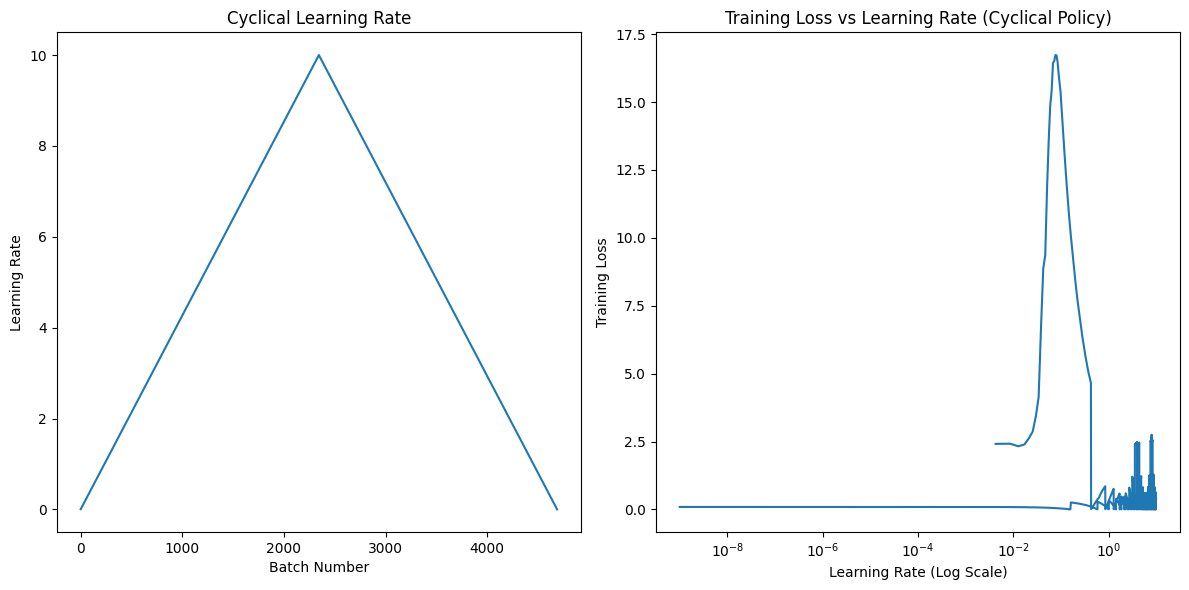

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#Plot loss as function of LR
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(lrs)
plt.xlabel("Batch Number")
plt.ylabel("Learning Rate")
plt.title("Cyclical Learning Rate")


plt.subplot(1, 2, 2)
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Learning Rate (Cyclical Policy)")

plt.tight_layout()
plt.show()


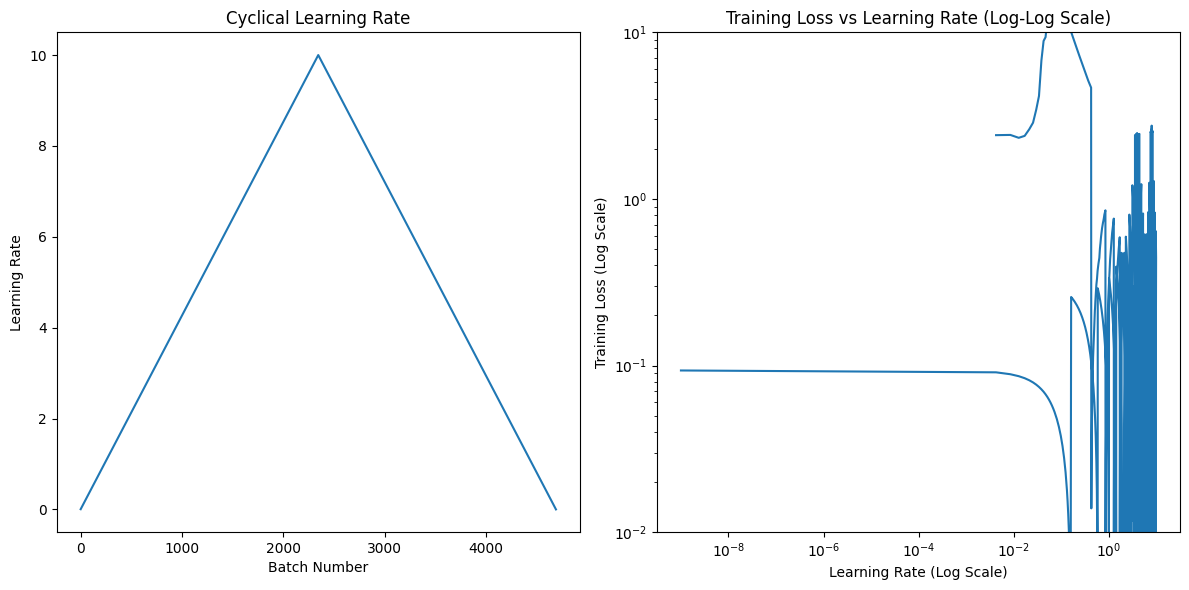

In [6]:
import matplotlib.pyplot as plt
import numpy as np

filtered_indices = [i for i, lr in enumerate(lrs) if 1e-9 <= lr <= 10]
filtered_lrs = np.array(lrs)[filtered_indices]
filtered_losses = np.array(losses)[filtered_indices]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lrs)
plt.xlabel("Batch Number")
plt.ylabel("Learning Rate")
plt.title("Cyclical Learning Rate")

plt.subplot(1, 2, 2)
plt.plot(filtered_lrs, filtered_losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Training Loss (Log Scale)")
plt.title("Training Loss vs Learning Rate (Log-Log Scale)")
plt.ylim(0.01, 10)
plt.tight_layout()
plt.show()


Epoch 1/5 | Train Loss: 0.3439, Train Acc: 88.06% | Val Loss: 0.3366, Val Acc: 88.19%
Epoch 2/5 | Train Loss: 0.2880, Train Acc: 89.95% | Val Loss: 0.2877, Val Acc: 89.96%
Epoch 3/5 | Train Loss: 0.2439, Train Acc: 91.42% | Val Loss: 0.2303, Val Acc: 91.61%
Epoch 4/5 | Train Loss: 0.1648, Train Acc: 94.12% | Val Loss: 0.1963, Val Acc: 93.29%
Epoch 5/5 | Train Loss: 0.0997, Train Acc: 96.41% | Val Loss: 0.1809, Val Acc: 93.86%


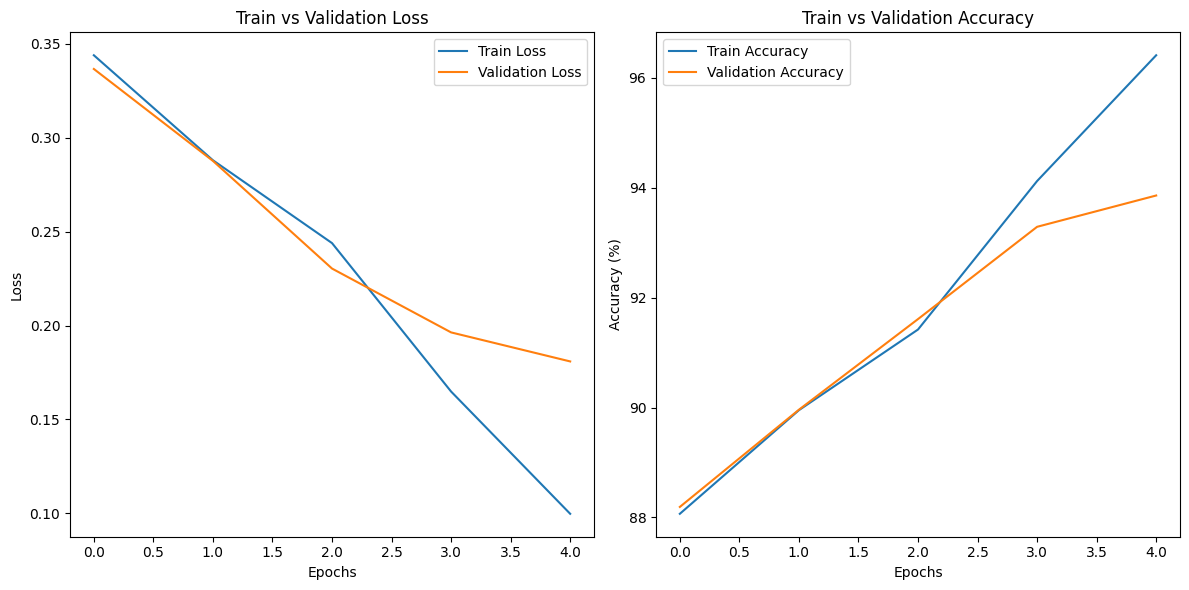

In [11]:
# cyclical learning rate between 1e-4 and 1e-2

# Initialize optim/ scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=len(trainloader)*5//2, mode='triangular', cycle_momentum=False)

# train for 5 epochs
epochs = 5
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    net.train()

    #Train
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        #Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()  #Update lr after batch

        running_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    #Train acc loss
    train_losses.append(running_train_loss / len(trainloader))
    train_acc.append(100. * correct_train / total_train)

    #Val loop
    net.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(testloader))
    val_acc.append(100. * correct_val / total_val)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

# Plotting results
plt.figure(figsize=(12, 6))

# Plot train vs val loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

#Plot train vs val acc
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1, Batch Size: 32, Train Loss: 0.7390
Epoch 2, Batch Size: 64, Train Loss: 0.5611
Epoch 3, Batch Size: 128, Train Loss: 0.4432
Epoch 4, Batch Size: 256, Train Loss: 0.4234
Epoch 5, Batch Size: 512, Train Loss: 0.5049
Epoch 6, Batch Size: 1024, Train Loss: 0.5501
Epoch 7, Batch Size: 2048, Train Loss: 0.7536


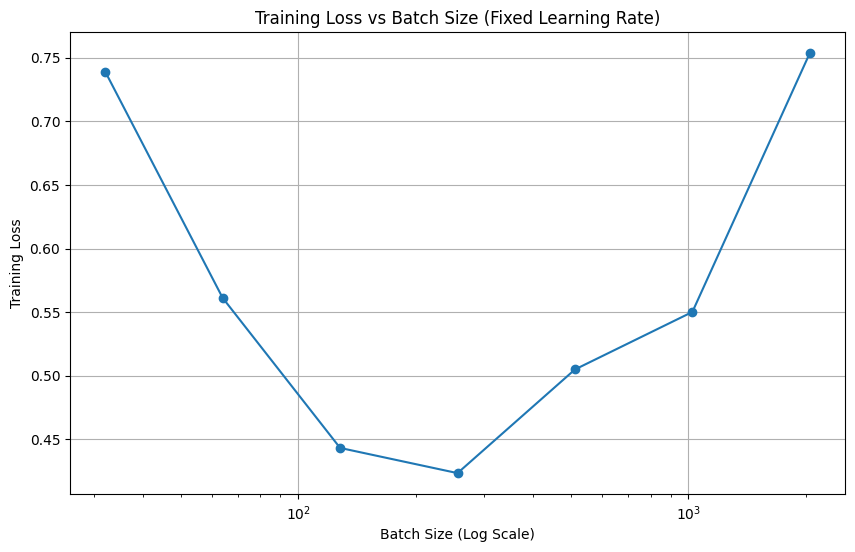

In [13]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Function to train with varying batch sizes
def train_with_increasing_batch_sizes(lrmax, initial_batch_size, max_batch_size, epoch_count):
    batch_sizes = []
    train_losses = []

    for epoch in range(epoch_count):
        # double batch size
        current_batch_size = initial_batch_size * (2 ** epoch)
        if current_batch_size > max_batch_size:
            break

        # new dataloader
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=current_batch_size, shuffle=True)

        # init model with fixed lr
        net = InceptionSmall().to(device)
        optimizer = optim.SGD(net.parameters(), lr=lrmax, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        running_loss = 0.0

        #train
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        #Calculate average loss
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        batch_sizes.append(current_batch_size)

        print(f"Epoch {epoch + 1}, Batch Size: {current_batch_size}, Train Loss: {avg_loss:.4f}")

    return batch_sizes, train_losses

# Parameters
lrmax = 1e-2
initial_batch_size = 32
max_batch_size = 4096
epoch_count = 7

batch_sizes, train_losses = train_with_increasing_batch_sizes(lrmax, initial_batch_size, max_batch_size, epoch_count)

plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, train_losses, marker='o')
plt.xscale('log')
plt.xlabel('Batch Size (Log Scale)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Batch Size (Fixed Learning Rate)')
plt.grid(True)
plt.show()


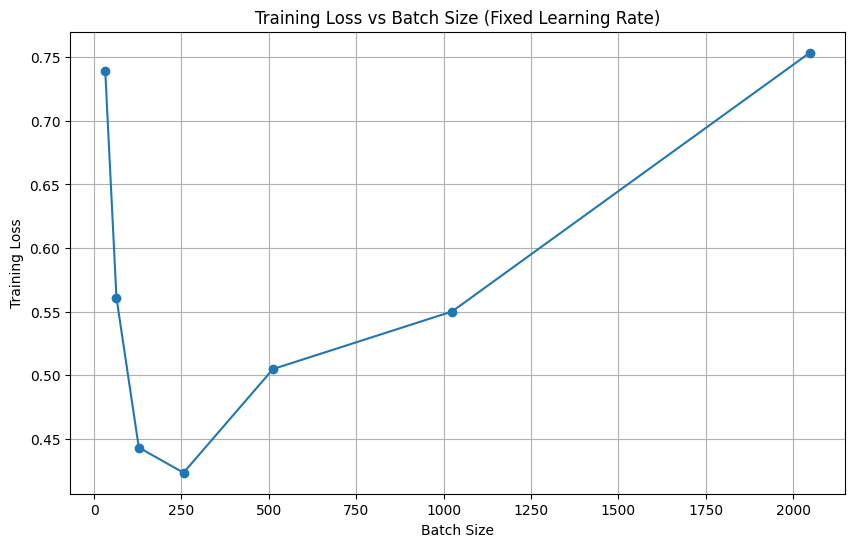

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, train_losses, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Batch Size (Fixed Learning Rate)')
plt.grid(True)
plt.show()


The graph and results for the varying batch sizes show that training loss decreases as the batch size increases initially, reaching a minimum at batch size 256 with a loss of 0.4234. However, as the batch size continues to increase, the training loss begins to rise again, peaking at 0.7536 for a batch size of 2048. This suggests that while smaller batch sizes may initially lead to higher losses, very large batch sizes do not necessarily yield better performance and can, in fact, hurt generalization. The cyclical learning rate approach is a more balanced generalization, especially with moderate batch sizes like 64/128/256.







